# Chapter 15 - Processing Sequences Using RNNs and CNNs Code Reproduction

In [41]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# untuk membuat output notebook ini stabil di setiap proses run
np.random.seed(42)
tf.random.set_seed(42)

# Untuk plot gambar yang bagus
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

<ipython-input-42-2a0864a99de4>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14, loc="upper left")


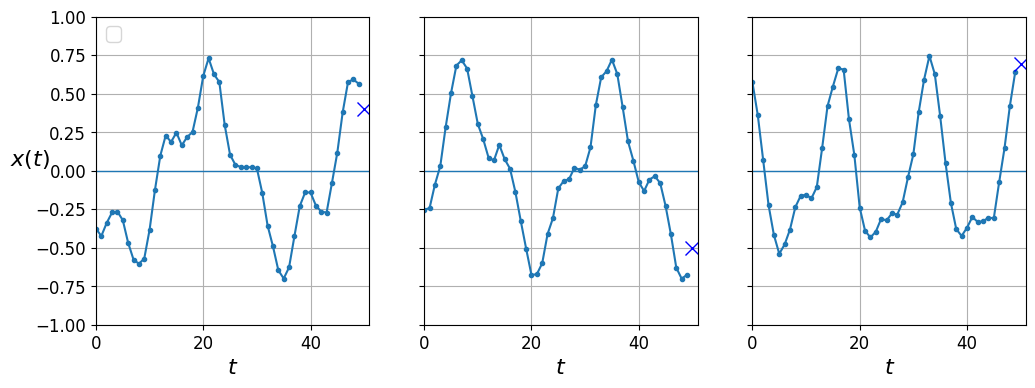

In [42]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend:
        plt.legend(fontsize=14, loc="upper left")

# Membuat dataset
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

# Menampilkan contoh data
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

In [44]:
# Prediksi naif (naive forecast)
y_pred = X_valid[:, -1]
print("MSE Prediksi Naif:", np.mean(tf.keras.losses.MeanSquaredError()(y_valid, y_pred)))

# Model Linear
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0)
print("MSE Model Linear:", model.evaluate(X_valid, y_valid))

MSE Prediksi Naif: 0.020211369


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
MSE Model Linear: 0.003335379995405674


In [45]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0)
print("MSE RNN Sederhana:", model.evaluate(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
MSE RNN Sederhana: 0.01094934344291687


In [46]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0)
print("MSE Deep RNN:", model.evaluate(X_valid, y_valid))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
MSE Deep RNN: 0.0030179203022271395


In [47]:
# Menyiapkan data untuk prediksi 10 langkah
n_steps = 50
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

# Membangun model baru dengan output layer yang memiliki 10 neuron
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
# (Langkah pelatihan untuk model ini akan membutuhkan data yang disiapkan secara berbeda,
# namun arsitekturnya ditunjukkan di sini)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Helper function untuk membuat dataset windowed
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    return dataset.batch(batch_size).prefetch(1)

# Membuat dataset windowed
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = windowed_dataset(y_train, window_size, 128, 10000)
valid_set = windowed_dataset(y_valid, window_size, 128, 1000)

# Model LSTM
model_lstm = keras.models.Sequential([
  keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
  keras.layers.LSTM(32),
  keras.layers.Dense(1),
])
# (Kompilasi dan pelatihan untuk LSTM)

# Model GRU
model_gru = keras.models.Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(32),
    keras.layers.Dense(1),
])
# (Kompilasi dan pelatihan untuk GRU)

# Model CNN gaya WaveNet
model_wavenet = keras.models.Sequential()
model_wavenet.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model_wavenet.add(keras.layers.Conv1D(filters=32, kernel_size=2, padding="causal",
                                          activation="relu", dilation_rate=rate))
model_wavenet.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Kompilasi model WaveNet
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=3e-3)
model_wavenet.compile(loss="mse", optimizer=optimizer,
                      metrics=["mae"])
history = model_wavenet.fit(train_set, epochs=100,
                            validation_data=valid_set,
                            callbacks=[lr_schedule], verbose=0)
print("MSE Model WaveNet:", model_wavenet.evaluate(valid_set))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can gener

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1507 - mae: 0.3385
MSE Model WaveNet: [0.15175074338912964, 0.3393389582633972]


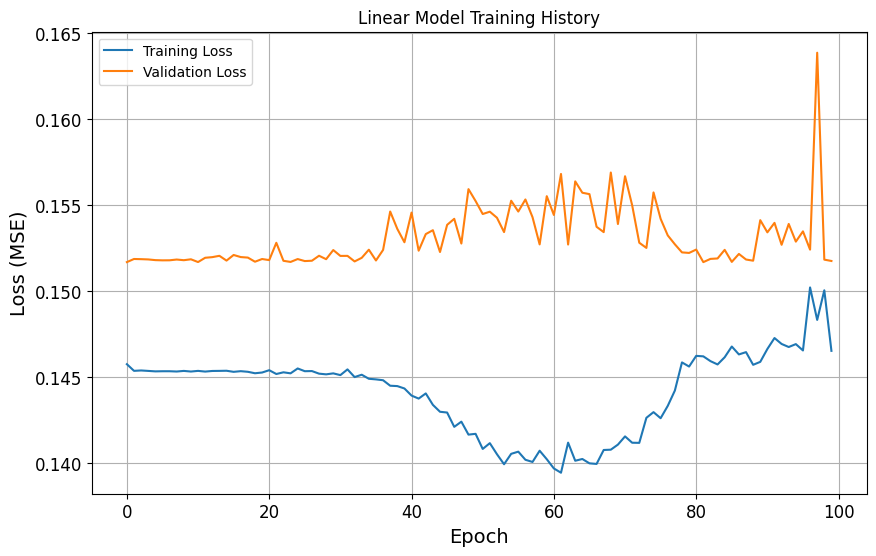

In [49]:
# Plot training history for Linear Model
if 'history' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Linear Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Training history for Linear Model not available.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


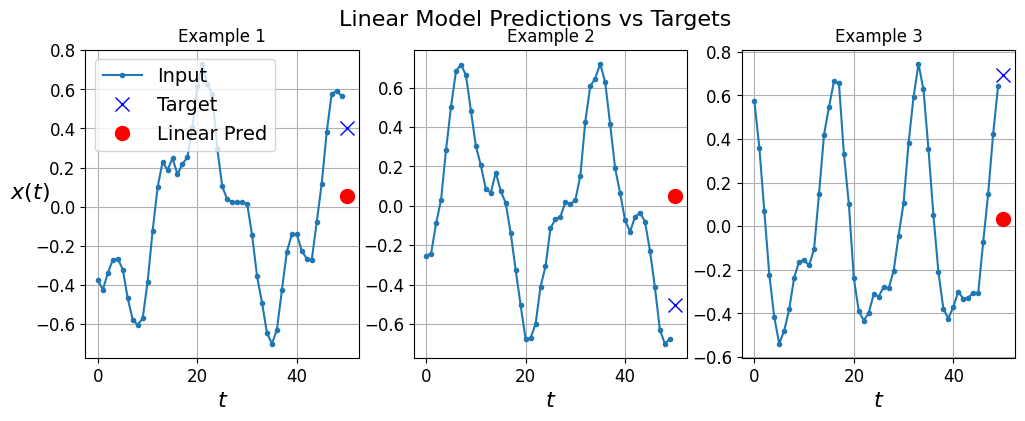

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


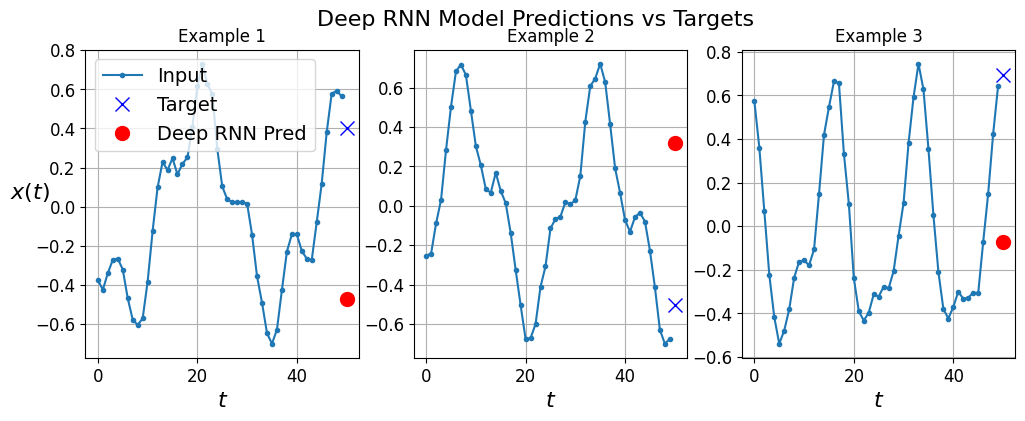

In [50]:
# Select a few examples from the validation set
n_examples = 3
X_sample = X_valid[:n_examples]
y_sample = y_valid[:n_examples]

# Make predictions with the Linear Model
if 'linear_model' in locals():
    y_pred_linear = linear_model.predict(X_sample)
    plt.figure(figsize=(12, 4))
    for i in range(n_examples):
        plt.subplot(1, n_examples, i + 1)
        plt.plot(np.arange(n_steps), X_sample[i, :, 0], ".-", label="Input")
        plt.plot(n_steps, y_sample[i, 0], "bx", markersize=10, label="Target")
        plt.plot(n_steps, y_pred_linear[i, 0], "ro", markersize=10, label="Linear Pred")
        plt.grid(True)
        plt.xlabel("$t$", fontsize=16)
        plt.title(f"Example {i+1}")
        if i == 0:
            plt.ylabel("$x(t)$", fontsize=16, rotation=0)
            plt.legend(fontsize=14, loc="upper left")
    plt.suptitle("Linear Model Predictions vs Targets", fontsize=16)
    plt.show()
else:
    print("Linear model not available.")

# Make predictions with the Deep RNN Model
if 'model' in locals(): # Assuming 'model' is the Deep RNN model from cell nOW305JxO8g7
    y_pred_deep_rnn = model.predict(X_sample)
    plt.figure(figsize=(12, 4))
    for i in range(n_examples):
        plt.subplot(1, n_examples, i + 1)
        plt.plot(np.arange(n_steps), X_sample[i, :, 0], ".-", label="Input")
        plt.plot(n_steps, y_sample[i, 0], "bx", markersize=10, label="Target")
        plt.plot(n_steps, y_pred_deep_rnn[i, 0], "ro", markersize=10, label="Deep RNN Pred")
        plt.grid(True)
        plt.xlabel("$t$", fontsize=16)
        plt.title(f"Example {i+1}")
        if i == 0:
            plt.ylabel("$x(t)$", fontsize=16, rotation=0)
            plt.legend(fontsize=14, loc="upper left")
    plt.suptitle("Deep RNN Model Predictions vs Targets", fontsize=16)
    plt.show()
else:
     print("Deep RNN model not available.")